# Plots to analyze and understand our data

In [3]:
!pip install pandas numpy matplotlib seaborn scikit-learn

Start by importing necessary libraries:

In [4]:
import csv
from collections import defaultdict
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
from DATASET import clean_df, numerical_df

Import all relevant files, as well as our merged dataset: 

In [5]:
file1 = './Students/Estudiants_èxit_accés_anònim.csv'
file2 = './Students/Estudiants_notes_assignatures_anònim.csv'
file3 = './Students/Estudiants_abandonament_anònim.csv'

## 1. Histogram of final grades

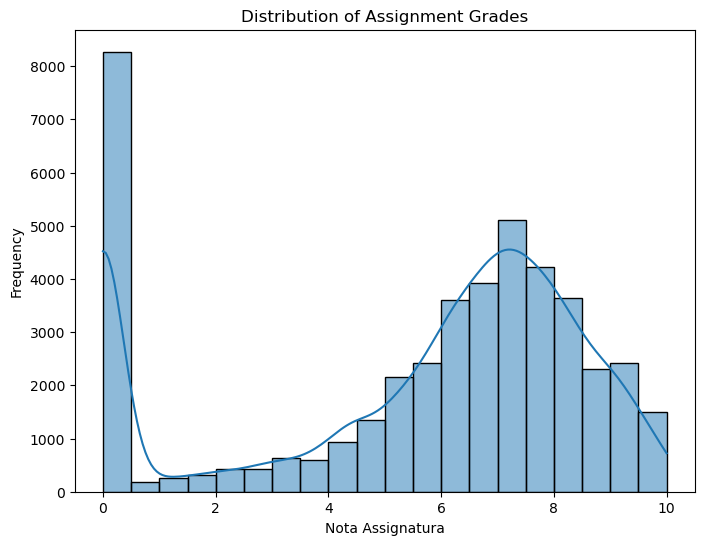

In [6]:
plt.figure(figsize=(8, 6))
sns.histplot(clean_df['nota_assignatura'], kde=True, bins=20)
plt.title('Distribution of Assignment Grades')
plt.xlabel('Nota Assignatura')
plt.ylabel('Frequency')
plt.show()



 > From the plot, we can see that there are many cases where students received a grade of 0. While the most common grades lie in the range between 4 and 10. We should inspect where all these zeros come from, if they are really student's marks or if they are related to other factors such as drop out.



We filtered the students of drop_out based on mark of the subject.
Also we count the number of times that they had a 0.

In [7]:
df_unique = clean_df.drop_duplicates(subset=['id_anonim'])
df_nota_cero = df_unique[df_unique['nota_assignatura'] == 0]
#print(df_nota_cero[['id_anonim', 'nota_d_acces', 'nota_assignatura']])

print("\nConteo de alumnos con nota 0 sin repetir id:")
print(df_nota_cero['nota_assignatura'].value_counts())

df_nota_cero_total = clean_df[clean_df['nota_assignatura'] == 0]
#print(df_nota_cero_total[['id_anonim', 'nota_d_acces', 'nota_assignatura']])
print("\nConteo de alumnos con nota 0 en total:")
print(df_nota_cero_total['nota_assignatura'].value_counts())

#Print els 5 primers alumnes amb nota 0
print("\nPrimeres 5 alumnes amb nota 0:")
resumen_suspensos = df_nota_cero_total.groupby('id_anonim').agg({
    'nota_assignatura': list,  # Notas con las que ha suspendido (deberían ser ceros)
    'assignatura': list,       # Asignaturas en las que ha suspendido
    'curs_academic': lambda x: sorted(set(x)),  # Años cursados
    'taxa_exit': list,        # Tasa de éxito
}).reset_index()

# Añadir número de años cursados
resumen_suspensos['num_anys_cursats'] = resumen_suspensos['curs_academic'].apply(len)

# Mostrar ejemplo de los primeros 5 alumnos
print(resumen_suspensos.head(5))


Conteo de alumnos con nota 0 sin repetir id:
nota_assignatura
0.0    248
Name: count, dtype: int64

Conteo de alumnos con nota 0 en total:
nota_assignatura
0.0    8134
Name: count, dtype: int64

Primeres 5 alumnes amb nota 0:
                          id_anonim                     nota_assignatura  \
0  0066119860f58ba306ac800f52623ac0  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]   
1  00665c4df2b06078706c9c96e9f6c117            [0.0, 0.0, 0.0, 0.0, 0.0]   
2  0082201cb9ab09cfd6556b10ee6844de                                [0.0]   
3  00b029250c1614ff1cd14c5fb7bd70d3            [0.0, 0.0, 0.0, 0.0, 0.0]   
4  00db10edb3f63b6caafe420dc0b06811                 [0.0, 0.0, 0.0, 0.0]   

                                         assignatura       curs_academic  \
0  [Àlgebra, Càlcul, Electricitat i electrònica, ...           [2023/24]   
1  [Càlcul, Fonaments dels computadors, Matemàtic...           [2024/25]   
2                               [Crèdits reconeguts]           [2021/22]   
3  [Arquitec

La majoria de gent que té un 0 a les assignatures només han cursat 2 anys. What happen when taxa d'èxit = 1 and nota_assignatura = 0?

In [8]:
# Filtramos los estudiantes con nota 0
students_with_zero_grades = clean_df[clean_df['nota_assignatura'] == 0]

# Agrupar por 'Id Anonim' y contar cuántos años diferentes han cursado cada estudiante
students_with_zero_grades['num_anys_cursats'] = students_with_zero_grades.groupby('id_anonim')['curs_academic'].transform('nunique')

# Contamos cuántos estudiantes con nota 0 han cursado más de un año académico
students_continued = students_with_zero_grades[students_with_zero_grades['num_anys_cursats'] > 1]
students_continued_count = students_continued['nota_assignatura'].count()
print(f"Total de estudiantes con nota 0 que han continuado (más de un año académico): {students_continued_count}")

# Ahora, contamos cuántos estudiantes con nota 0 solo han cursado un año académico (posible abandono)
students_one_year = students_with_zero_grades[students_with_zero_grades['num_anys_cursats'] == 1]

students_one_year_count = students_one_year['nota_assignatura'].count()
print(f"Total de estudiantes con nota 0 que solo cursaron un año académico: {students_one_year_count}")

students_finish = students_with_zero_grades[students_with_zero_grades['num_anys_cursats'] >= 4]
students_finish_count = students_finish['nota_assignatura'].count()
print(f"Total de estudiantes con nota 0 que han terminado (más de 4 años académicos): {students_finish_count}")
# Distribución de asignaturas con nota 0
assignment_zero_counts = students_with_zero_grades['assignatura'].value_counts()
print(f"Distribución de asignaturas con nota 0:\n{assignment_zero_counts}")



Total de estudiantes con nota 0 que han continuado (más de un año académico): 3147
Total de estudiantes con nota 0 que solo cursaron un año académico: 4987
Total de estudiantes con nota 0 que han terminado (más de 4 años académicos): 314
Distribución de asignaturas con nota 0:
assignatura
Crèdits reconeguts                            1113
Metodologia de la programació                  443
Organització i gestió d'empreses               426
Matemàtica discreta                            328
Arquitectura de computadors                    327
                                              ... 
Tecnologies de compressió de la informació       1
Fonaments d'aprenentatge automàtic               1
Fonaments de la visió per computador             1
Ment i cervell i                                 1
Visió i aprenentatge                             1
Name: count, Length: 97, dtype: int64


/var/folders/mk/3cn5djzn6zg__7grqj55pmsc0000gp/T/ipykernel_32156/1281568352.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  students_with_zero_grades['num_anys_cursats'] = students_with_zero_grades.groupby('id_anonim')['curs_academic'].transform('nunique')


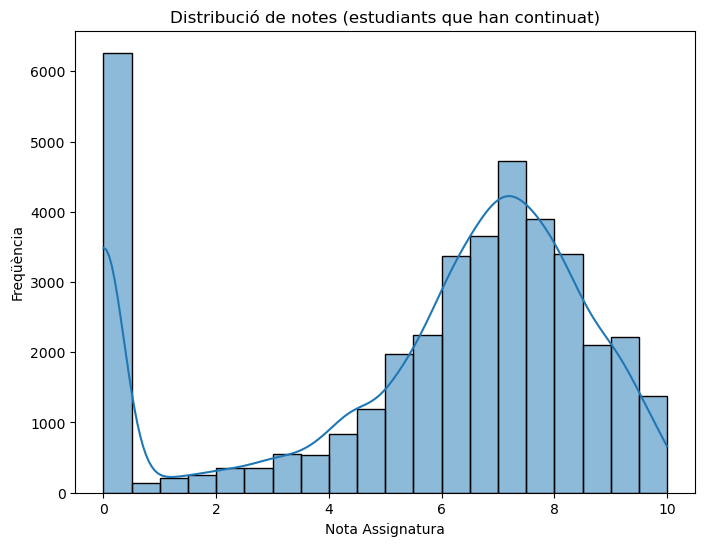

In [9]:
# Primero calculamos cuántos años ha cursado cada estudiante
clean_df['num_anys_cursats'] = clean_df.groupby('id_anonim')['curs_academic'].transform('nunique')

# Filtramos solo los estudiantes que han cursado más de un año
students_multiyear = clean_df[clean_df['num_anys_cursats'] > 1]

# Hacemos el histograma de sus notas
plt.figure(figsize=(8, 6))
sns.histplot(students_multiyear['nota_assignatura'], kde=True, bins=20)
plt.title('Distribució de notes (estudiants que han continuat)')
plt.xlabel('Nota Assignatura')
plt.ylabel('Freqüència')
plt.show()

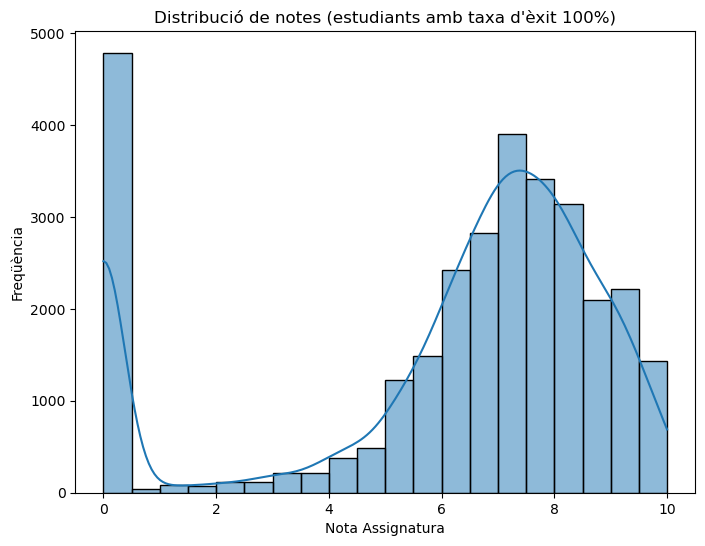

In [10]:
# Asegúrate de que 'taxa_exit' es numérico
clean_df['taxa_exit'] = pd.to_numeric(clean_df['taxa_exit'], errors='coerce')

# Filtra estudiantes con taxa d'èxit == 1.0
students_successful = clean_df[clean_df['taxa_exit'] == 1.0]

# Graficar las notas de asignatura para estos estudiantes
plt.figure(figsize=(8, 6))
sns.histplot(students_successful['nota_assignatura'], kde=True, bins=20)
plt.title('Distribució de notes (estudiants amb taxa d\'èxit 100%)')
plt.xlabel('Nota Assignatura')
plt.ylabel('Freqüència')
plt.show()

In [11]:
# Asegurarse de tipos numéricos
students_multiyear = students_multiyear.drop_duplicates(subset=['id_anonim'])
students_multiyear['taxa_exit'] = pd.to_numeric(students_multiyear['taxa_exit'], errors='coerce')
students_multiyear['nota_assignatura'] = pd.to_numeric(students_multiyear['nota_assignatura'], errors='coerce')

# Filtrar incoherencias: taxa_exit = 1.0 pero nota = 0.0
incoherentes = students_multiyear[(students_multiyear['taxa_exit'] == 1.0) & (students_multiyear['nota_assignatura'] == 0.0)]

# Mostrar 5 ejemplos
print(incoherentes.head(5))


                                estudi curs_academic  \
144  Graduat en enginyeria informàtica       2020/21   
364  Graduat en enginyeria informàtica       2020/21   
688  Graduat en enginyeria informàtica       2020/21   
711  Graduat en enginyeria informàtica       2020/21   
822  Graduat en enginyeria informàtica       2020/21   

                            id_anonim  sexe                  assignatura  \
144  B00d385b35cedafd7b69dd3c9a70734a  Dona                  Compiladors   
364  1fdae19e9797228e67dde7bd40272c43  Home  Arquitectura de computadors   
688  510f91c0e300c04020d5ce078565b8f6  Home           Crèdits reconeguts   
711  017301a753b1ef36dd045a4c2c6dc1df  Dona           Crèdits reconeguts   
822  99de6321ce933121be75baee545b6041  Home  Arquitectura de computadors   

     codi_assignatura  nota_assignatura     via_acces_estudi  nota_d_acces  \
144            102782               0.0  Batx. / cou amb pau         6.376   
364            102775               0.0           

La majoria de gent que té un 0 a les assignatures només han cursat 2 anys. What happen when taxa d'èxit = 1 and nota_assignatura = 0?

In [12]:
students_with_zero_and_full_exit = clean_df[
    (clean_df['taxa_exit'] == 1.0) & (clean_df['nota_assignatura'] == 0.0)
]
# Buscar repeticiones aprobadas
def check_if_repeated_and_passed(row):
    repeated = clean_df[
        (clean_df['id_anonim'] == row['id_anonim']) &
        (clean_df['codi_assignatura'] == row['codi_assignatura']) &
        (clean_df['nota_assignatura'] > 0)
    ]
    return not repeated.empty

students_with_zero_and_full_exit['repeated_and_passed'] = students_with_zero_and_full_exit.apply(
    check_if_repeated_and_passed, axis=1
)

num_cases = students_with_zero_and_full_exit[students_with_zero_and_full_exit['repeated_and_passed'] == True].shape[0]
print(f"Total de casos que han repetido la assignatura y la han aprobado: {num_cases}")

Total de casos que han repetido la assignatura y la han aprobado: 483


/var/folders/mk/3cn5djzn6zg__7grqj55pmsc0000gp/T/ipykernel_32156/547186461.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  students_with_zero_and_full_exit['repeated_and_passed'] = students_with_zero_and_full_exit.apply(


Cuantas veces han repetido las assignaturas?

In [13]:
repetitions = (
    clean_df.groupby(['id_anonim', 'codi_assignatura'])['curs_academic']
    .nunique()
    .reset_index(name='num_repeticions')
)

repetitions = repetitions[repetitions['num_repeticions'] > 1]
repeats_by_student = repetitions.groupby('id_anonim')['num_repeticions'].max().value_counts().sort_index()

for i in range(2, 6):
    count = repeats_by_student.get(i, 0)
    print(f"Estudiantes que han repetido una asignatura {i} veces: {count}")

Estudiantes que han repetido una asignatura 2 veces: 544
Estudiantes que han repetido una asignatura 3 veces: 239
Estudiantes que han repetido una asignatura 4 veces: 51
Estudiantes que han repetido una asignatura 5 veces: 4


In [14]:
repeated_assignments = []

# Iteramos sobre cada fila del dataframe filtrado
for _, row in students_with_zero_and_full_exit.iterrows():
    student_id = row['id_anonim']
    subject_code = row['codi_assignatura']
    
    # Buscar todas las filas de ese estudiante con esa asignatura
    records = clean_df[
        (clean_df['id_anonim'] == student_id) &
        (clean_df['codi_assignatura'] == subject_code)
    ].sort_values('curs_academic')
    
    # Verificar que hay más de una entrada (que la repitió)
    if len(records) > 1 and any(records['nota_assignatura'] > 0):
        repeated_assignments.append(records)

for i, df in enumerate(repeated_assignments[:3]):
    print(f"\n📘 Ejemplo {i+1}:")
    display(df[['id_anonim', 'assignatura', 'curs_academic', 'nota_assignatura']])


📘 Ejemplo 1:


,id_anonim,assignatura,curs_academic,nota_assignatura
59,F4537a70eeeafbae2094f3ad4a203f24,Enginyeria del software,2020/21,0.0
8774,F4537a70eeeafbae2094f3ad4a203f24,Enginyeria del software,2021/22,5.9



📘 Ejemplo 2:


,id_anonim,assignatura,curs_academic,nota_assignatura
144,B00d385b35cedafd7b69dd3c9a70734a,Compiladors,2020/21,0.0
8841,B00d385b35cedafd7b69dd3c9a70734a,Compiladors,2021/22,8.7



📘 Ejemplo 3:


,id_anonim,assignatura,curs_academic,nota_assignatura
472,C666c52f821b78fe69a293a2d25dc99e,Compiladors,2020/21,0.0
9151,C666c52f821b78fe69a293a2d25dc99e,Compiladors,2021/22,0.0
17036,C666c52f821b78fe69a293a2d25dc99e,Compiladors,2022/23,0.0
25261,C666c52f821b78fe69a293a2d25dc99e,Compiladors,2023/24,5.3


Quan es repeteixen 4 cops el mateix alumne en el mateix any es perquè la taxa d'exit varia. Això ho hem descobert investigant un cas concret:

In [15]:
df_filtered = clean_df[
    (clean_df['id_anonim'] == 'F4537a70eeeafbae2094f3ad4a203f24') &
    (clean_df['assignatura'] == 'Enginyeria del software') &
    (clean_df['curs_academic'] == '2021/22')
]

print(df_filtered.T) 

print("Duplicados exactos:", df_filtered.duplicated().sum())

                                                       8774
estudi                    Graduat en enginyeria informàtica
curs_academic                                       2021/22
id_anonim                  F4537a70eeeafbae2094f3ad4a203f24
sexe                                                   Home
assignatura                         Enginyeria del software
codi_assignatura                                     102743
nota_assignatura                                        5.9
via_acces_estudi                        Batx. / cou amb pau
nota_d_acces                                          8.252
dedicacio_de_l_estudiant                      Temps complet
discapacitat                                              N
beca_concedida                                           No
estudis_mare                       Diplomat o enginyer tèc.
estudis_pare                       Diplomat o enginyer tèc.
taxa_exit                                               1.0
abandonament                            

Distribution of marks about the students that have finished the degree (4 or more years)

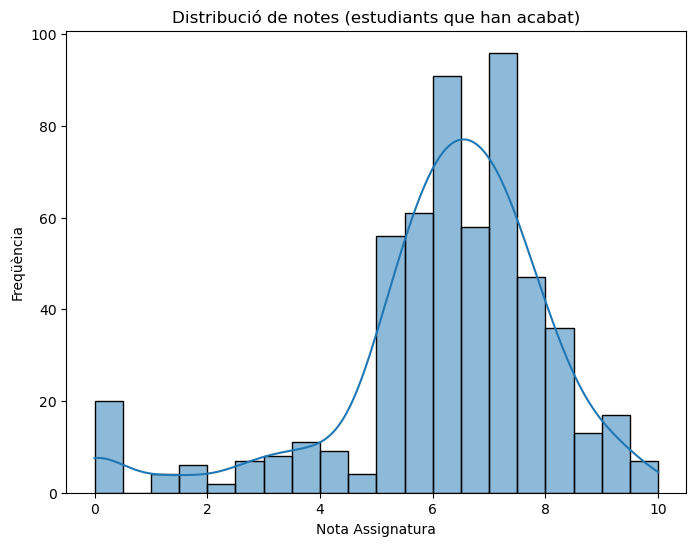

Total de personas en el dataset: 2006
Estudiantes que han acabado en 4 años exactos: 390
Estudiantes que han acabado repitiendo (más de 4 años): 163
Total de estudiantes que han terminado: 553
Estudiantes que no han terminado (menos de 4 años): 1453
Estudiantes que han abandonado: 211
Estudiantes activos que no han terminado aún: 1242


In [16]:
clean_df['num_anys_cursats'] = clean_df.groupby('id_anonim')['curs_academic'].transform('nunique')
students_finish = clean_df[clean_df['num_anys_cursats'] >= 4]
students_finish_unique = students_finish.drop_duplicates(subset='id_anonim', keep='first')
students_finish_count = students_finish_unique['nota_assignatura'].count()

plt.figure(figsize=(8, 6))
sns.histplot(students_finish_unique['nota_assignatura'], kde=True, bins=20)
plt.title('Distribució de notes (estudiants que han acabat)')
plt.xlabel('Nota Assignatura')
plt.ylabel('Freqüència')
plt.show()

finished_4_years = students_finish_unique[students_finish_unique['num_anys_cursats'] == 4]
finished_more_years = students_finish_unique[students_finish_unique['num_anys_cursats'] > 4]

total_personas = clean_df['id_anonim'].nunique()
print(f"Total de personas en el dataset: {total_personas}")
print(f"Estudiantes que han acabado en 4 años exactos: {len(finished_4_years)}")
print(f"Estudiantes que han acabado repitiendo (más de 4 años): {len(finished_more_years)}")
print(f"Total de estudiantes que han terminado: {students_finish_count}")

not_finished = clean_df[clean_df['num_anys_cursats'] < 4]
not_finished_unique = not_finished.drop_duplicates(subset='id_anonim', keep='first')
print(f"Estudiantes que no han terminado (menos de 4 años): {len(not_finished_unique)}")
abandoned = clean_df[clean_df['abandonament'] == 1]
abandoned_unique = abandoned.drop_duplicates(subset='id_anonim', keep='first')
print(f"Estudiantes que han abandonado: {len(abandoned_unique)}")
active_not_finished = not_finished_unique[not_finished_unique['abandonament'] == 0]
print(f"Estudiantes activos que no han terminado aún: {len(active_not_finished)}")

## 2. Identifying clusters in the data
This code will cluster students based on their background data and grades, and then compare the clusters. We will use KMeans clustering to group students based on their background and grades. We will also visualize the clusters using PCA for dimensionality reduction.

In [17]:
df_background = pd.read_csv(file1)

# Select and preprocess relevant features
df_background_filtered = df_background[[  
    'Id Anonim',
    'Sexe',
    'Via Accés Estudi',
    'Nota d\'accés (preinscripció)',
    'Dedicació de l\'estudiant',
    'Beca Concedida?',
]].dropna(subset=['Nota d\'accés (preinscripció)'])  # Ensure valid grades

# One-hot encode categorical variables
# Primero cargamos de nuevo el dataframe procesado
df = df_background_filtered.copy()

#### 1st Grouping: Id Anonim vs Nota d'accés

In [18]:
# we use DBSCAN to group closer grades
marks_scaler = StandardScaler()
scaled_marks = marks_scaler.fit_transform(df[['Nota d\'accés (preinscripció)']])

dbscan_marks = DBSCAN(eps=0.05, min_samples=1)  # small eps for similar marks
marks_clusters = dbscan_marks.fit_predict(scaled_marks)

# Save grades cluster
df['Cluster_same_grade'] = marks_clusters

#### 2nd Grouping: Id Anonim vs Características sociodemográficas

In [19]:
# Select characteristics to group
features = [
    'Beca Concedida?', 
    'Via Accés Estudi', 
    'Sexe',
    'Dedicació de l\'estudiant'
]

# encode categorical variables
df_features_encoded = pd.get_dummies(df[features], drop_first=True)

# Scale features
scaler_features = StandardScaler()
features_scaled = scaler_features.fit_transform(df_features_encoded)

# Clustering based on sociodemographic similarities
dbscan_features = DBSCAN(eps=0.5, min_samples=1)
clusters_features = dbscan_features.fit_predict(features_scaled)

# Save sociodemographical clustering
df['Cluster_profile'] = clusters_features

#### Result

In [20]:
# Show final dataframe
print(df[['Id Anonim', 'Nota d\'accés (preinscripció)', 'Cluster_same_grade', 'Cluster_profile']])

df_unique = df.drop_duplicates(subset=['Id Anonim'])

sns.set_theme(style="whitegrid")

                             Id Anonim  Nota d'accés (preinscripció)  \
0     1DFB71F2B000D1421808D0B3F67B335E                        10.798   
1     C26BD2D93ECB81CCB559D5B01B51475B                         6.512   
2     7526FB10E35C2E8808213E923F8F6125                        11.468   
3     FE20EBA7DC6B312D1F2FEA0A76D8E32D                        10.102   
4     22F995020F697929585BBADAC92CAB20                        10.870   
...                                ...                           ...   
5049  1DD45B64CD99F09F05CFD1494A2759D8                        10.306   
5050  B00599E75FAEA4201E19D6423F7A586F                        11.170   
5051  43E857A43F0C47B06C897EE1B5420859                        11.326   
5052  AB84122CC95E9606BF1105B1493AF177                        10.894   
5053  561BCC27E5BF6BF4318B71754314D3F2                         0.000   

      Cluster_same_grade  Cluster_profile  
0                      0                0  
1                      0                1  
2  

#### First Plot: Grouping by marks

/var/folders/mk/3cn5djzn6zg__7grqj55pmsc0000gp/T/ipykernel_32156/1222727505.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_unique['Grupo_manual'] = df_unique["Nota d'accés (preinscripció)"].apply(clasifica_nota)


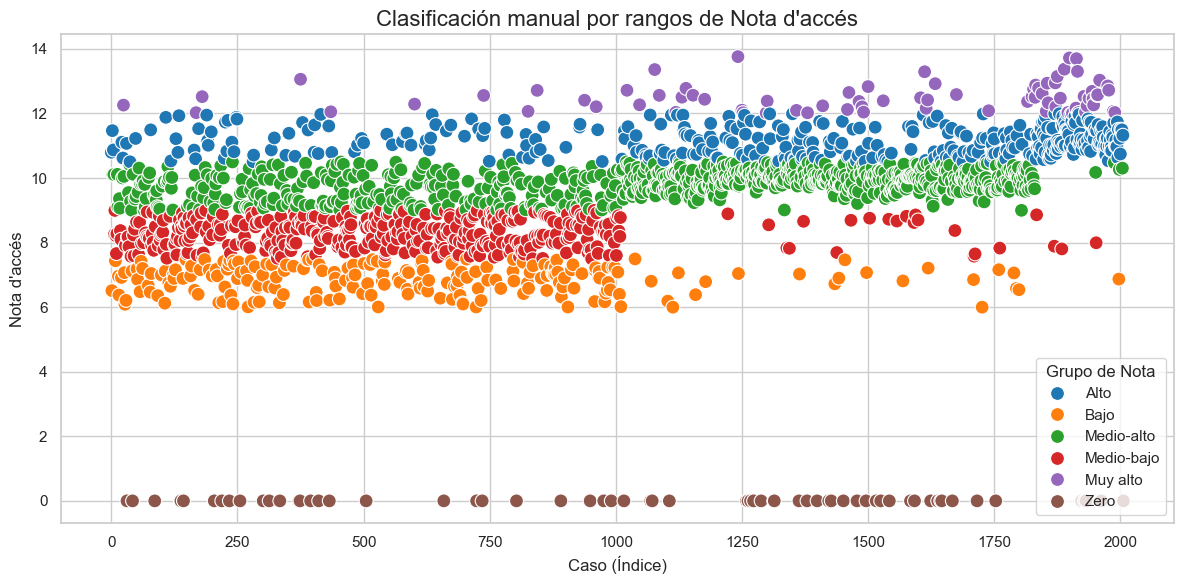

In [21]:
def clasifica_nota(nota):
    if 0 == nota:
        return 'Zero'
    if 6 <= nota < 7.5:
        return 'Bajo'
    elif 7.5 <= nota < 9:
        return 'Medio-bajo'
    elif 9 <= nota < 10.5:
        return 'Medio-alto'
    elif 10.5 <= nota <= 12:
        return 'Alto'
    elif 12 < nota <= 14:
        return 'Muy alto'


# Aplicar clasificación
df_unique['Grupo_manual'] = df_unique["Nota d'accés (preinscripció)"].apply(clasifica_nota)

# Plot con rangos personalizados como hue
plt.figure(figsize=(12, 6))
sns.scatterplot(
    x=range(len(df_unique)),
    y="Nota d'accés (preinscripció)",
    hue="Grupo_manual",
    palette="tab10",
    data=df_unique,
    s=100
)
plt.title("Clasificación manual por rangos de Nota d'accés", fontsize=16)
plt.xlabel("Caso (Índice)")
plt.ylabel("Nota d'accés")
plt.legend(title="Grupo de Nota")
plt.tight_layout()
plt.show()

### Notas con 0

In [22]:
df_nota_cero = df_unique[df_unique['Nota d\'accés (preinscripció)'] == 0]

# Mostrar los resultados
print(df_nota_cero[['Id Anonim', 'Nota d\'accés (preinscripció)', 'Cluster_same_grade', 'Cluster_profile']])

# Además, podemos ver cuántos hay por cluster de nota
print("\nConteo de alumnos con nota 0 por cluster:")
print(df_nota_cero['Cluster_same_grade'].value_counts())

df_nota_cero_original = clean_df[clean_df["nota_d_acces"] == 0]

# Mostrar las primeras 5 filas completas
pd.set_option('display.max_columns', None)  # Mostrar todas las columnas
print(df_nota_cero_original.head(5))
#Because is not assigned.
#Graduat en Enginyeria Informàtica,2020/21,831467D928E1E6F50F9FC15B8D8E2CB0,Home,2020/21,Sense assignar,0,Temps parcial,N,Sí,Sense assignar,Sense assignar,80%

                             Id Anonim  Nota d'accés (preinscripció)  \
31    543339F552E0B0E988D8BBBD6465185B                           0.0   
42    30278E0F8EC87AE905B2AB401F617D6F                           0.0   
86    831467D928E1E6F50F9FC15B8D8E2CB0                           0.0   
137   04A1AE722E3F56CC3436FA0B61780FEA                           0.0   
138   445BE2A471D3ED342F0A28E9001EB713                           0.0   
...                                ...                           ...   
4777  A0E10025CAC3F238A1AA7386278C6421                           0.0   
4787  24165D6D52FBA82831D8613682F9B864                           0.0   
4799  724BBB0359CC4FD95A904381D1ECCCFE                           0.0   
4886  927F18E8554CD4F63B5844CC1D2A1C84                           0.0   
5053  561BCC27E5BF6BF4318B71754314D3F2                           0.0   

      Cluster_same_grade  Cluster_profile  
31                     1               14  
42                     1               16  
86 

In [23]:

# Filtrar estudiantes que cumplen las 3 condiciones
df_nota_cero_2024_un_solo_any = clean_df[
    (clean_df["nota_d_acces"] == 0) &
    (clean_df["curs_academic"] == "2024/25") &
    (clean_df["num_anys_cursats"] == 1)
]

# Contar únicos estudiantes
total = df_nota_cero_2024_un_solo_any['id_anonim'].nunique()
print(f"Total de estudiantes con nota d'accés 0 en 2024/25 que solo han cursado un año: {total}")


Total de estudiantes con nota d'accés 0 en 2024/25 que solo han cursado un año: 6


Las notas con 0 en la nota de acceso se deben a q no esta asignado la via de acceso a la universidad entonces no sabmeos la nota de acceso. Hemos ido a observar cuantos de estos es su primer curso en la universidad, el cual necessitamos su background de la nota de acceso para precedir su nota en los modelos. 
En vez de esto, podemos borrar esa row porque nosotras no tenemos esa data por protección de datos però en el campus virtual si que la tenemos, no deberiamos preocupar-nos. Sino podemos hacer la media de todos los valores de la mayoria y entrenarlo con eso.

#### Second Plot: Sociodemographical Profile

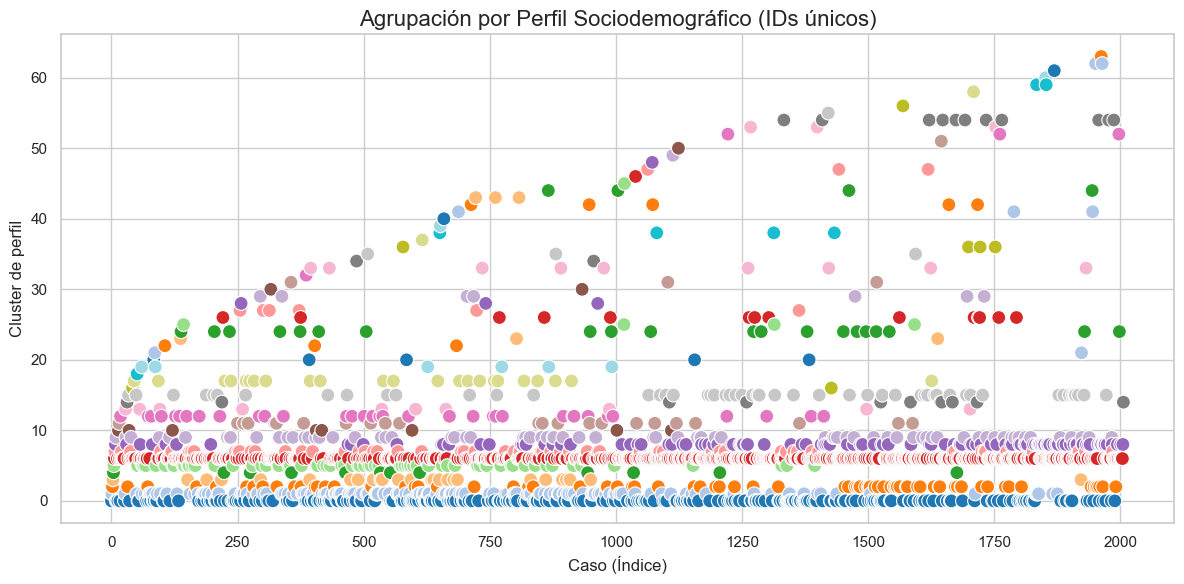

In [24]:
plt.figure(figsize=(12, 6))
ax = sns.scatterplot(
    x=range(len(df_unique)),  
    y='Cluster_profile',
    hue='Cluster_profile',
    palette='tab20',
    data=df_unique,
    s=100
)
plt.title('Agrupación por Perfil Sociodemográfico (IDs únicos)', fontsize=16)
plt.xlabel('Caso (Índice)')
plt.ylabel('Cluster de perfil')
ax.legend_.remove()  # <-- REMOVED THE LEGEND SO THAT THE PLOT FITS!
plt.tight_layout()
plt.show()

## 3. Visualizing our data through PCA

Here we will be working with our merged dataframe, our goal is to visualize its structure, in order to do so, we will reduce its dimensions to 3 principal components using PCA, and plot them in order to have some general idea about how our data looks like.

Since PCA can only be applied on numerical features, we will use the numerical version of our dataset, where we encoded the values into numbers.

In [25]:
# create a copy of our dataframe
df = numerical_df.copy()

# ensure that our dataframe only contains numerical values
df.dtypes

estudi                        int64
curs_academic                 int64
sexe                          int64
nota_assignatura            float64
via_acces_estudi              int64
nota_d_acces                float64
dedicacio_de_l_estudiant      int64
discapacitat                  int64
beca_concedida                int64
estudis_mare                  int64
estudis_pare                  int64
taxa_exit                   float64
abandonament                  int64
dificultat_assignatura      float64
dtype: object

We will now begin by scaling our data. Specifically, we will only scale the continuous features (such as the marks), as most of the other features are categorical.

In [26]:
# Select continuous features to scale
continuous_features = ['nota_assignatura', 'nota_d_acces', 'taxa_exit', 'dificultat_assignatura']

# Instantiate the scaler
scaler = StandardScaler()

# Fit and transform the continuous features
df[continuous_features] = scaler.fit_transform(df[continuous_features])

Next, we'll apply PCA to reduce the dataset's dimensionality to three principal components. 

In [27]:
from sklearn.decomposition import PCA
from matplotlib.lines import Line2D

# Apply PCA (exclude the target 'nota_assignatura')
pca = PCA(n_components=3)
pca_result = pca.fit_transform(df.drop(columns=['nota_assignatura']))

# Create PCA result DataFrame
pca_df = pd.DataFrame(data=pca_result, columns=['PC1', 'PC2', 'PC3'])

Now we'll create a 3D plot where each point is colored based on the student's degree. This will allow us to see if there are any patterns or clusters in the data.

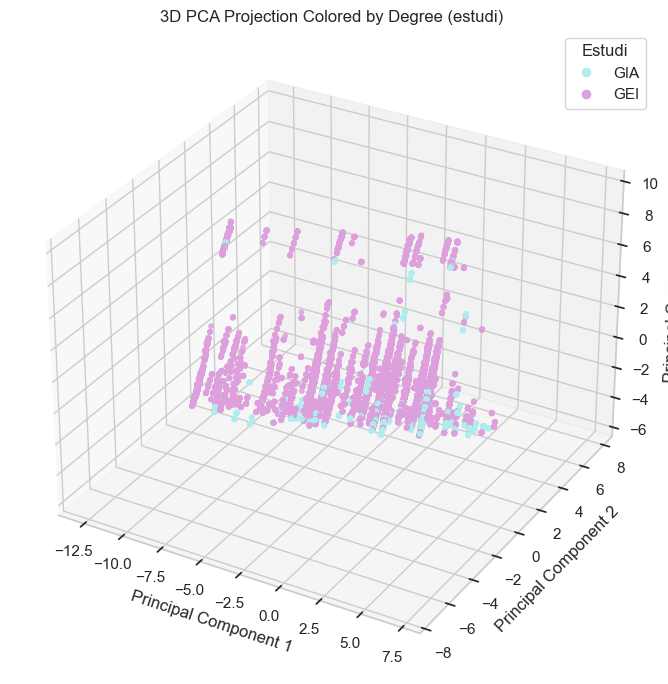

In [28]:
# Add the 'estudi' column back for coloring
pca_df['estudi'] = df['estudi'].values

# Set colors based on 'estudi' (0 or 1)
color_map = {0: 'paleturquoise', 1: 'plum'}
colors = pca_df['estudi'].map(color_map)

# 3D Plot
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

sc = ax.scatter(pca_df['PC1'], pca_df['PC2'], pca_df['PC3'], c=colors, alpha=0.8, s=10)

# Labels and title
ax.set_title('3D PCA Projection Colored by Degree (estudi)')
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')

# Add custom legend
legend_elements = [
    Line2D([0], [0], marker='o', color='w', label='GIA', markerfacecolor='paleturquoise', markersize=8),
    Line2D([0], [0], marker='o', color='w', label='GEI', markerfacecolor='plum', markersize=8)
]
ax.legend(handles=legend_elements, title="Estudi")

plt.tight_layout()
plt.show()


> The plot reveals that there are fewer AI students compared to Computer Science students. Most AI students appear to be concentrated in a specific region of the 3D space, whereas Computer Science students are more widely distributed throughout the entire space. This could signify that there are differences between the features of an AI degree student and the features of a computer science student (e.g. in the entrance grade required, final subject marks etc)

Now we will do the same but instead of coloring the points according to their degree, we will do so according to their gender:

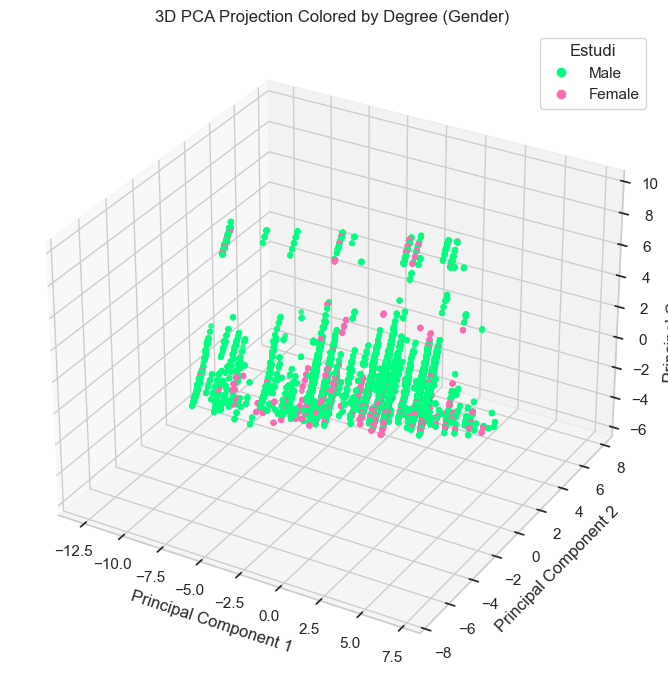

In [29]:
# Add the 'estudi' column back for coloring
pca_df['sexe'] = df['sexe'].values

# Set colors based on 'estudi' (0 or 1)
color_map = {0: 'springgreen', 1: 'hotpink'}
colors = pca_df['sexe'].map(color_map)

# 3D Plot
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

sc = ax.scatter(pca_df['PC1'], pca_df['PC2'], pca_df['PC3'], c=colors, alpha=0.8, s=10)

# Labels and title
ax.set_title('3D PCA Projection Colored by Degree (Gender)')
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')

# Add custom legend
legend_elements = [
    Line2D([0], [0], marker='o', color='w', label='Male', markerfacecolor='springgreen', markersize=8),
    Line2D([0], [0], marker='o', color='w', label='Female', markerfacecolor='hotpink', markersize=8)
]
ax.legend(handles=legend_elements, title="Estudi")

plt.tight_layout()
plt.show()

> The plot reveals that there are more male than female students across both degree programs. In terms of their distribution in the 3D space, the data points for both genders largely overlap, with no clear separation between the two groups. This suggests that gender does not significantly influence the features represented in the dataset.

## 4. Complementing PCA's results

All in all, even though we could extract some meaningful information from it, PCA was not as informative as we could have though. The reasons behind this could be that features are mainly shared across groups, or that PCA (being linear) might not be the best tool to separate our data. Therefore what we will do in this section is to focuse on those two features that we explored (degree and gender) as well as in other ones, in order to try to extract more information and complement our previous results.

/var/folders/mk/3cn5djzn6zg__7grqj55pmsc0000gp/T/ipykernel_32156/328707089.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='estudi', y='nota_assignatura', data=degree_df, errorbar='sd', palette='pastel')


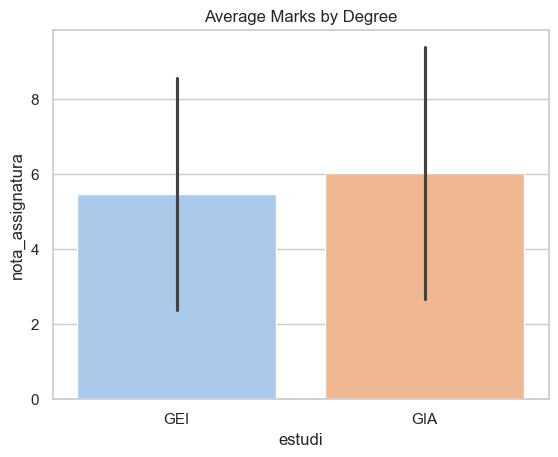

In [30]:
# Create a copy of the numerical DataFrame with names mapped
df = numerical_df.copy()
df['estudi'] = df['estudi'].map({0: 'GIA', 1: 'GEI'})

# Extract only the columns of interest
degree_df = df[['estudi', 'nota_assignatura']]

# Plot
sns.barplot(x='estudi', y='nota_assignatura', data=degree_df, errorbar='sd', palette='pastel')
plt.title('Average Marks by Degree')
plt.show()

> From the plot, we can conclude that students from the AI degree program have slightly higher performance than those from the Computer Science program. Therefore, the degree is an important feature that can help predict a student's mark. As we observe in the plot, the difference is not huge; however, it is still informative to know the degree to which a student belongs.

/var/folders/mk/3cn5djzn6zg__7grqj55pmsc0000gp/T/ipykernel_32156/3205039025.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='sexe', y='nota_assignatura', data=marks_df, errorbar='sd', palette='pastel')


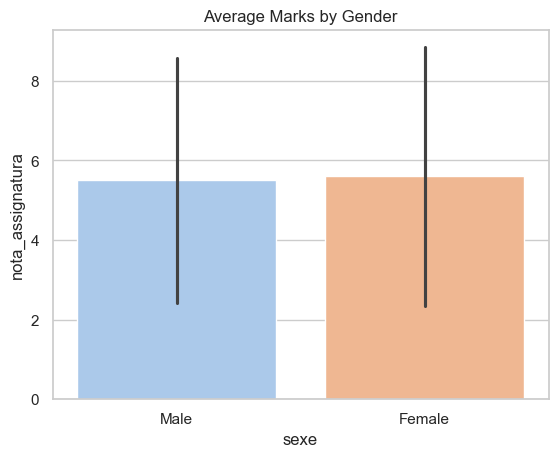

In [39]:
# Create a copy of the DataFrame with gender mapped
df = clean_df.copy()
df['sexe'] = df['sexe'].map({'Home': 'Male', 'Dona': 'Female'})

# Extract only the columns of interest
marks_df = df[['sexe', 'nota_assignatura']]

# Plot
sns.barplot(x='sexe', y='nota_assignatura', data=marks_df, errorbar='sd', palette='pastel')
plt.title('Average Marks by Gender')
plt.show()

> This plot confirms the pattern observed in the PCA analysis: the average marks of female and male students are very similar, with a slightly higher performance among female students. Nevertheless, this suggests that while gender may have a minor influence, it is not a key factor to consider when predicting student marks.

## 5. Exploring Feature Importance via Correlation Matrix Analysis

*We will plot to Get a First General Understanding of How Features Relate to the Success of a Student*

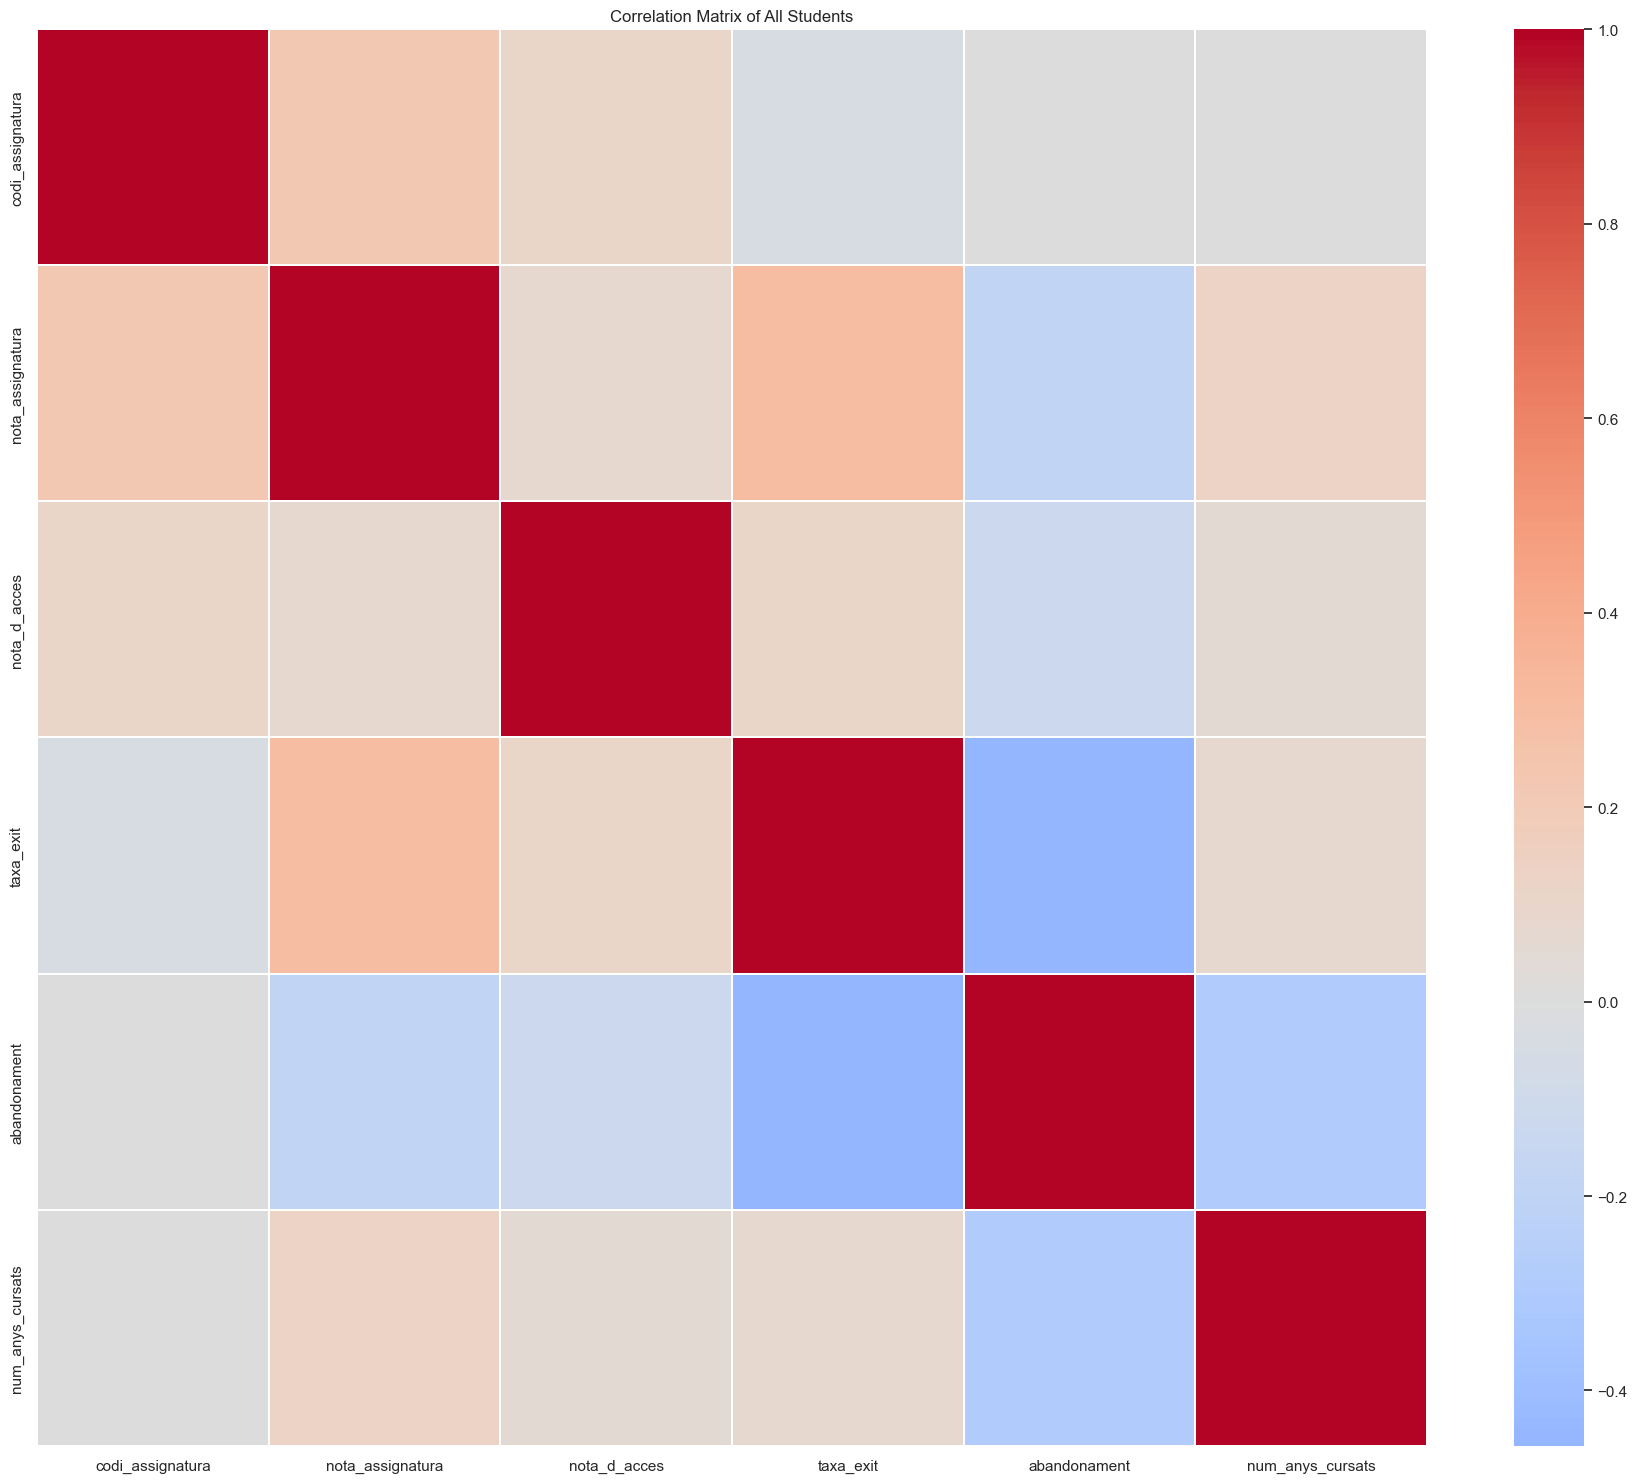

In [41]:
df_corr = clean_df.copy()

# We will drop columns that are not usefull
cols_to_drop = ['Student_ID', 'Curs acadèmic', 'Assignatura', 'Codi assignatura', 'Perfil']
df_corr = df_corr.drop(columns=cols_to_drop, errors='ignore')
df_corr = pd.get_dummies(df_corr, drop_first=True)
df_corr = df_corr.dropna()
df_corr = df_corr.select_dtypes(include=[np.number])

correlation_matrix = df_corr.corr()

plt.figure(figsize=(18, 15))
sns.heatmap(correlation_matrix, cmap='coolwarm', center=0, annot=False, linewidths=0.3)
plt.title('Correlation Matrix of All Students')
plt.tight_layout()
plt.show()


### Initial Hypothesis

> 1. Prior Academic Performance Predicts University Grades
> - **Variable**: `Nota d'accés (preinscripció)`
> - **Observation**: Strong positive correlation with `Nota_assignatura`
> - **Hypothesis**: Students who enter university with higher admission scores tend to perform better academically at the subject level
> 
> 2. University Dropouts Are Linked to Lower Grades
> - **Variables**: `Nombre Abandonaments Universitat`, `Nombre Abandonaments Universitat Reals`, `Nombre Abandonaments Universitat Reals criteri 1 any`, `Nombre Abandonaments Universitat Reals 1r any criteri 1 any`
> - **Observation**: All show negative correlations with course grades.
> - **Hypothesis**: Students with a history of university abandonment, especially early in their studies, tend to have lower grades.
> 
> 3. Receiving Financial Aid May Be Associated with Better Performance
> - **Variable**: `Beca Concedida?_Sí`
> - **Observation**: Positive correlation with course grades.
> - **Hypothesis**: Students who receive financial aid may perform better due to institutional support, reduced financial stress, or selective aid criteria.
> 
> 4. Gender Might Affect Academic Outcomes
> - **Variable**: `Sexe_Home`
> - **Observation**: Slight negative correlation with grades.
> - **Hypothesis**: Male students may, on average, perform slightly worse than female students in the dataset. This could be explored further by field of study.